In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift
from scipy import signal
from scipy.signal import correlate, windows
from scipy.stats import rice

In [23]:
# --- Simulación del Canal de Desvanecimiento Rayleigh (Dominio del Tiempo) ---
def rayleigh_channel(V_kmh, f_c, T_sim, F_s):
    """
    Genera un proceso de desvanecimiento Rayleigh simplificado.
    (Basado en el modelo de Jakes modificado)
    """
    V_ms = V_kmh / 3.6 # (m/s)
    lambda_vac = 3e8 / f_c # (m)
    f_d = V_ms / lambda_vac # (Hz)
    T_0 = np.sqrt(0.5625/np.pi) / f_d # (s) # También se puede usar 0.423/f_d o 0.5/f_d

    N = int(T_sim * F_s)
    t = np.arange(N) / F_s
    
    # Modelo Jakes modificado (M=12 osciladores)
    M = 300
    N_0 = M // 2 # N_0 (M/2) osciladores no correlacionados
    omega_d = 2 * np.pi * f_d # La frecuencia angular de Doppler
    alpha = 2 * np.pi * np.arange(1, N_0 + 1) / (2 * N_0) # Ángulos de llegada uniformemente distribuidos
    phi_n = 2 * np.pi * np.random.rand(N_0) # Fases aleatorias para cada componente
    
    # Simulación de componentes I (en fase) y Q (en cuadratura)
    I_t = np.zeros(N)
    Q_t = np.zeros(N)

    # Suma de sinusoides
    for i in range(N_0):
        # I(t) y Q(t) son sumas de cosenos y senos
        I_t += np.cos(phi_n[i]) * np.cos(omega_d * t * np.cos(alpha[i]))
        Q_t += np.sin(phi_n[i]) * np.sin(omega_d * t * np.cos(alpha[i]))

    # El canal complejo h(t) = I(t) + j*Q(t), normalizado por la potencia media
    h_t = (I_t + 1j * Q_t) / np.sqrt(N_0)
    r_t_magnitude = np.abs(h_t) # Envolvente de Rayleigh
    r_t_dB = 10 * np.log10(r_t_magnitude**2 / np.mean(r_t_magnitude**2)) # Envolvente en dB (referencia a la media RMS)
    print(f"Frecuencia Portadora (f_c): {f_c/1e9:.1f} GHz")
    print(f"Velocidad del móvil (V): {V_kmh} km/h ({V_ms:.2f} m/s)")
    print(f"Dispersión Doppler Máxima (f_d): {f_d:.2f} Hz")
    print(f"Tiempo de Coherencia Aproximado (T_0): {T_0*1e3:.2f} ms")
    return t, T_0, f_d, h_t, r_t_dB, r_t_magnitude

def graph_temp(x, y, v, fc, T_0, T_s):
    """
    Representación en el Dominio del Tiempo
    """
    if T_0 < T_s:
        print("Canal de Desvanecimiento Rápido (Fast Fading)")
    else:
        print("Canal de Desvanecimiento Lento (Slow Fading)")
    plt.figure(figsize=(10, 5))
    plt.plot(x * 1000, y, label='Envolvente de Rayleigh (dB)') # Convertir a ms
    plt.xlabel('Tiempo Transcurrido (ms)')
    plt.ylabel('Nivel de Señal (dB relativo a RMS)')
    plt.title(f'Desvanecimiento Rayleigh de la Portadora (V={v} km/h, $f_c$={fc/1e9:.1f} GHz, $T_s$={T_s*1e3:.1f} ms)')
    plt.grid(True)
    plt.vlines(T_0 * 1000, -40, 10, colors='r', linestyles='dotted', label=f'$T_0 \\approx {T_0*1e3:.2f}$ ms')
    plt.vlines(T_s * 1000, -40, 10, colors='g', linestyles='solid', linewidth=5, alpha=0.3, label=f'$T_s$={T_s*1e3:.1f} ms')
    plt.legend()
    plt.show()

def graph_stadistical(magnitude):
    """
    Representación Estadística
    """
    plt.figure(figsize=(10, 5))
    plt.hist(magnitude, bins=50, density=True, color='skyblue', edgecolor='black', label='Simulación') # Histograma normalizado de la magnitud
    # PDF Teórica de Rayleigh
    sigma_sq = np.mean(magnitude**2) / 2
    r_range = np.linspace(0, magnitude.max(), 100)
    rayleigh_pdf = (r_range / sigma_sq) * np.exp(-r_range**2 / (2 * sigma_sq))
    plt.plot(r_range, rayleigh_pdf, 'r-', linewidth=2, label='Teórico Rayleigh PDF')
    plt.title('PDF de la Envolvente del Desvanecimiento (Rayleigh)')
    plt.xlabel('Amplitud de la Envolvente')
    plt.ylabel('Densidad de Probabilidad')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()


EPSILON = 1e-12 

def calculate_doppler_spectrum_corrected(h_t, F_s):
    """Calcula el Espectro de Potencia Doppler S(v) vía Autocorrelación."""
    
    # Autocorrelación R(Delta_t) del canal complejo
    R_delta_t = np.fft.ifft(np.fft.fft(h_t) * np.conj(np.fft.fft(h_t))) # Autocorrelación más eficiente
    R_delta_t = np.real(R_delta_t)
    R_delta_t = np.fft.fftshift(R_delta_t) / np.max(np.real(R_delta_t))

    # Aplicar ventana (Hann) y calcular FFT
    N_corr = len(R_delta_t)
    # Solo tomamos la mitad del espectro de autocorrelación para reducir ruido, 
    # aunque con el método ifft(fft*conj(fft)) ya es simétrico.
    # Vamos a usar el vector completo pero garantizando la simetría si es posible.
    
    window_fn = windows.hann(N_corr)
    R_delta_t_windowed = R_delta_t * window_fn
    
    S_v = np.fft.fft(R_delta_t_windowed)
    S_v = np.real(S_v) 
    
    # Mover DC al centro y generar eje de frecuencia
    S_v_shifted = np.fft.fftshift(S_v)
    
    # PISO DE RUIDO y NORMALIZACIÓN CRÍTICA
    # Aseguramos que S_v sea positivo antes de tomar el logaritmo
    S_v_shifted = S_v_shifted.clip(min=EPSILON) 
    
    # Normalizar el pico a 0 dB
    S_v_dB = 10 * np.log10(S_v_shifted / np.max(S_v_shifted))
    
    v = np.fft.fftfreq(N_corr, 1/F_s)
    v_shifted = np.fft.fftshift(v)
    
    return v_shifted, S_v_dB

def graph_doppler(v_slow, S_v_slow_dB, f_d_slow, V_slow, v_fast, S_v_fast_dB, f_d_fast, V_fast, W, type=str, xlim=(-100, 100), ylim=(-100, 10)):
    """Gráfica comparativa del Espectro Doppler."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(f'Espectro de Potencia Doppler (S(v)) - Variación Temporal - Canal {type}', fontsize=12)
    
    # --- Slow Fading ---
    ax1.plot(v_slow, S_v_slow_dB, label=f'V={V_slow} km/h, $f_d$={f_d_slow:.1f} Hz')
    ax1.axvline(x=f_d_slow, color='r', linestyle='--', label=f'Dispersión Doppler ($f_d$={f_d_slow:.1f} Hz)')
    ax1.axvline(x=-f_d_slow, color='r', linestyle='--')
    ax1.axvspan(-W/2, W/2, color='g', alpha=0.15, label=f'Ancho de banda de Señal ($W$={W:.1f} Hz)')
    ax1.set_xlim(xlim) # Centrar la visualización en la zona de interés
    ax1.set_ylim(ylim)
    ax1.set_title(f'Slow Fading: $W$ ({W:.1f} Hz) $>$ $f_d$ ({f_d_slow:.1f} Hz)', fontsize=11)
    ax1.set_ylabel('PSD (dB)')
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # --- Fast Fading ---
    ax2.plot(v_fast, S_v_fast_dB, label=f'V={V_fast} km/h, $f_d$={f_d_fast:.1f} Hz')
    ax2.axvline(x=f_d_fast, color='r', linestyle='--', label=f'Dispersión Doppler ($f_d$={f_d_fast:.1f} Hz)')
    ax2.axvline(x=-f_d_fast, color='r', linestyle='--')
    ax2.axvspan(-W/2, W/2, color='g', alpha=0.15, label=f'Ancho de banda de Señal ($W$={W:.1f} Hz)')
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.set_title(f'Fast Fading: $W$ ({W:.1f} Hz) $<$ $f_d$ ({f_d_fast:.1f} Hz)', fontsize=11)
    ax2.set_xlabel('Frecuencia Doppler (Hz)')
    ax2.set_ylabel('PSD (dB)')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    

In [24]:
# --- Parámetros del Entorno ---
f_c = 0.9e9 # (Hz)
V_slow = 5 # (km/h)
V_fast = 80 # (km/h)
T_sim_temp = 0.5  # (s)
T_sim_spec = 100.0 # (s)
F_s = 2000.0 # (samples/s)
T_s = 50e-3 # (s)
W = 1 / T_s # (Hz)

Frecuencia Portadora (f_c): 0.9 GHz
Velocidad del móvil (V): 5 km/h (1.39 m/s)
Dispersión Doppler Máxima (f_d): 4.17 Hz
Tiempo de Coherencia Aproximado (T_0): 101.55 ms
Canal de Desvanecimiento Lento (Slow Fading)


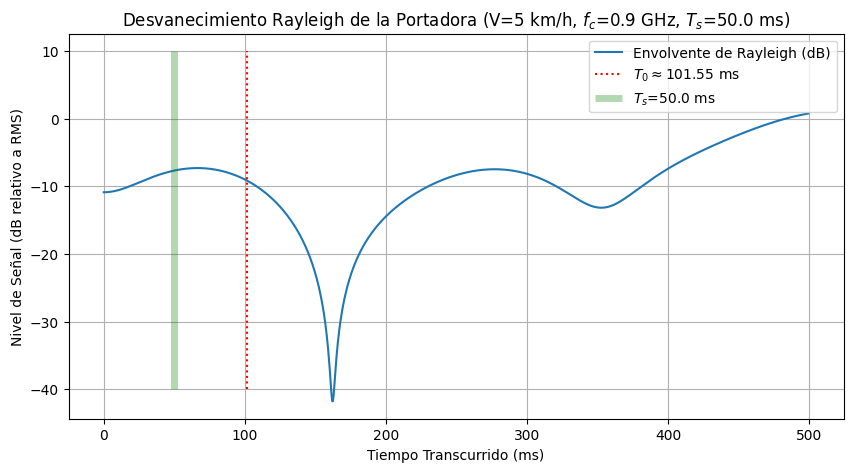

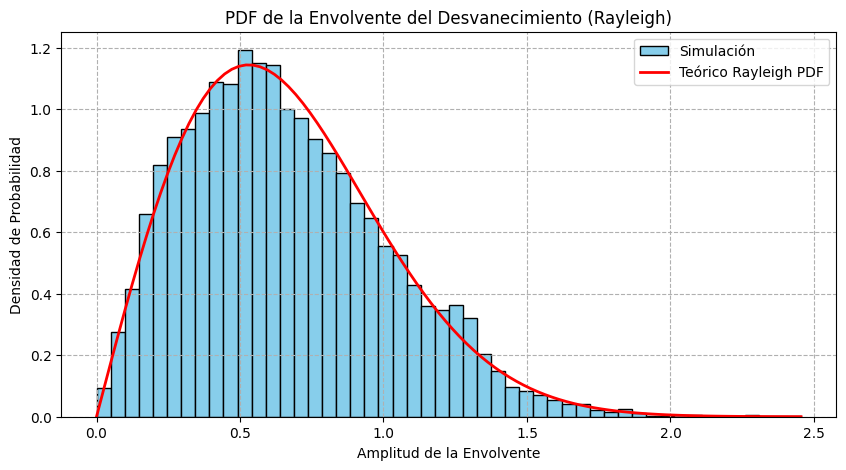

Frecuencia Portadora (f_c): 0.9 GHz
Velocidad del móvil (V): 80 km/h (22.22 m/s)
Dispersión Doppler Máxima (f_d): 66.67 Hz
Tiempo de Coherencia Aproximado (T_0): 6.35 ms
Canal de Desvanecimiento Rápido (Fast Fading)


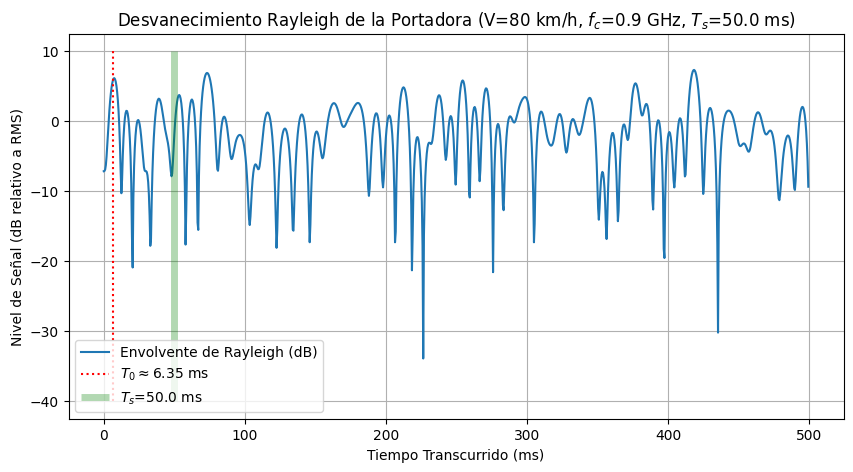

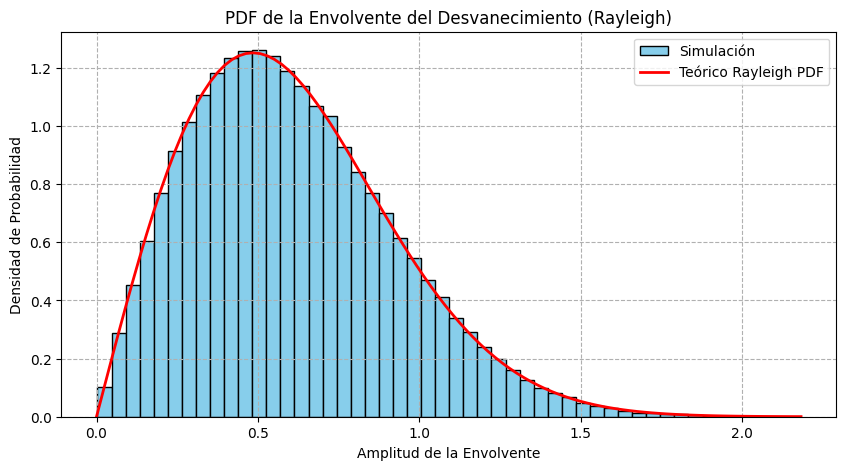

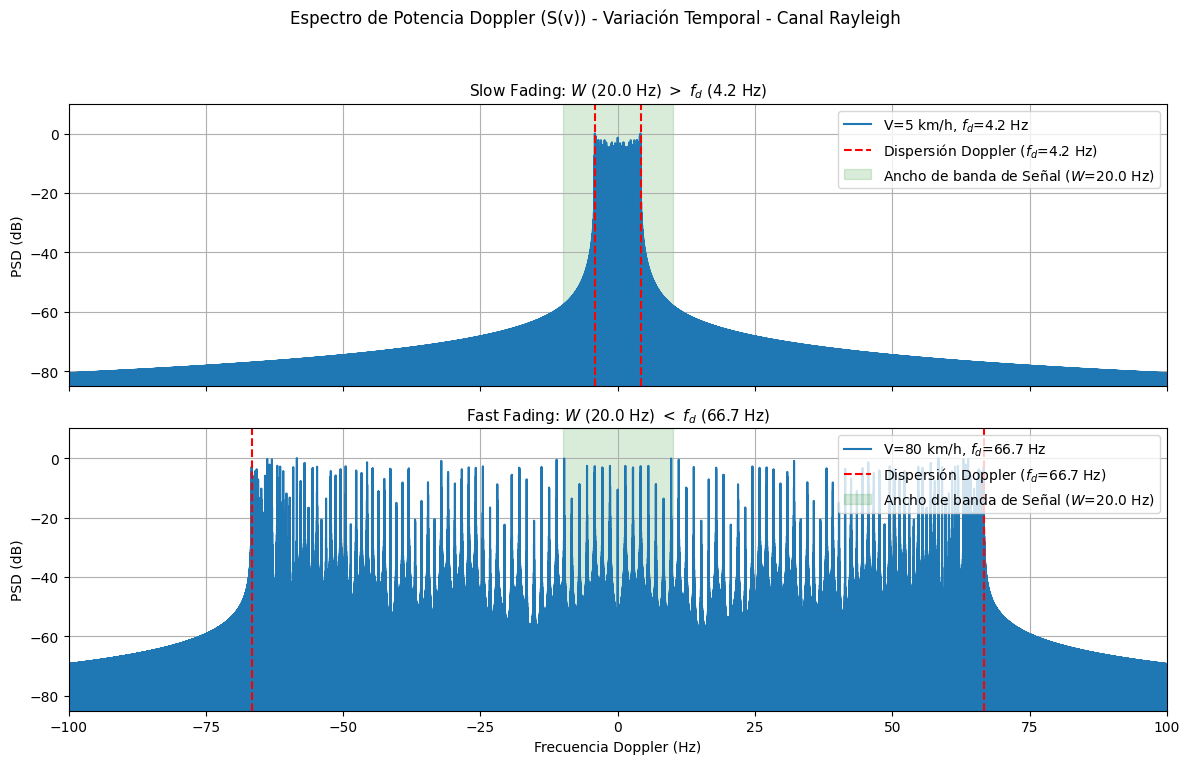

In [25]:
# --- Ejecución y Visualización ---
t_slow, T_0_slow, f_d_slow, h_slow_t, r_t_dB_slow, r_t_magnitude_slow = rayleigh_channel(V_slow, f_c, T_sim_spec, F_s)
# Gráfica Temporal (Usamos solo el tramo de 0.5s)
graph_temp(t_slow[:int(T_sim_temp * F_s)], r_t_dB_slow[:int(T_sim_temp * F_s)], V_slow, f_c, T_0_slow, T_s)
# Gráfica Estadística
graph_stadistical(r_t_magnitude_slow)
# Cálculo del Espectro
v_slow, S_v_slow_dB = calculate_doppler_spectrum_corrected(h_slow_t, F_s)

t_fast, T_0_fast, f_d_fast, h_fast_t, r_t_dB_fast, r_t_magnitude_fast = rayleigh_channel(V_fast, f_c, T_sim_spec, F_s)
graph_temp(t_fast[:int(T_sim_temp * F_s)], r_t_dB_fast[:int(T_sim_temp * F_s)], V_fast, f_c, T_0_fast, T_s)
graph_stadistical(r_t_magnitude_fast)
v_fast, S_v_fast_dB = calculate_doppler_spectrum_corrected(h_fast_t, F_s)

# Gráfica Comparativa del Espectro Doppler
graph_doppler(v_slow, S_v_slow_dB, f_d_slow, V_slow, v_fast, S_v_fast_dB, f_d_fast, V_fast, W, "Rayleigh", ylim=(-85,10))


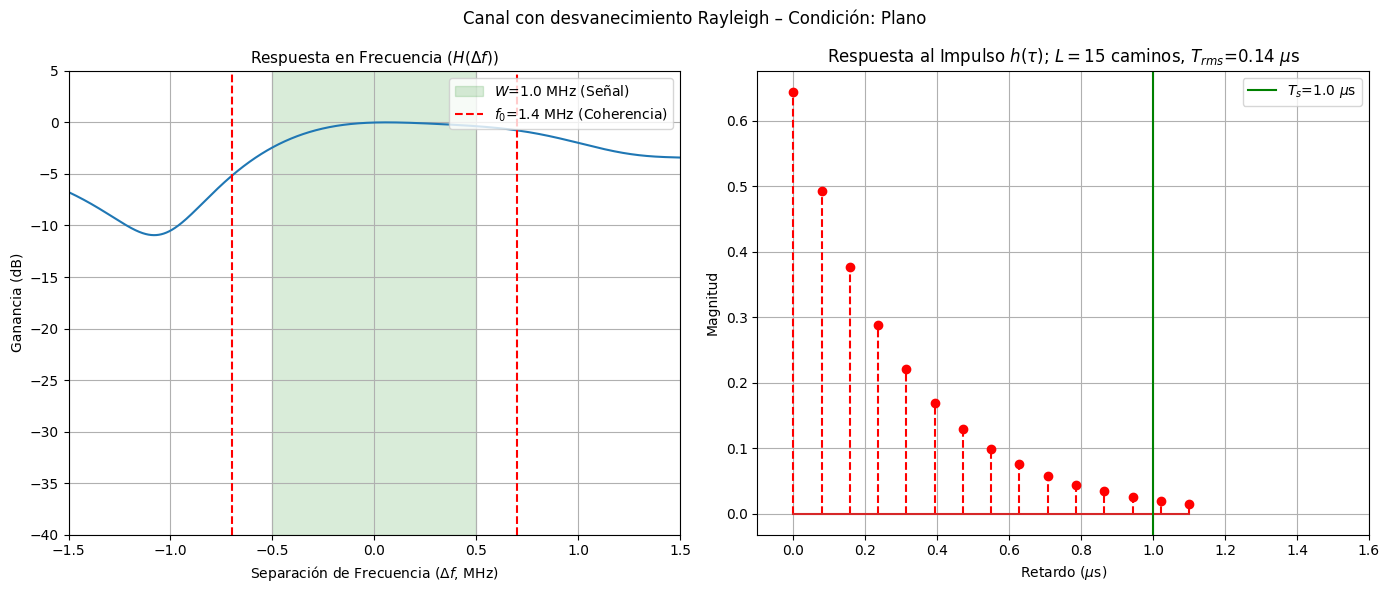

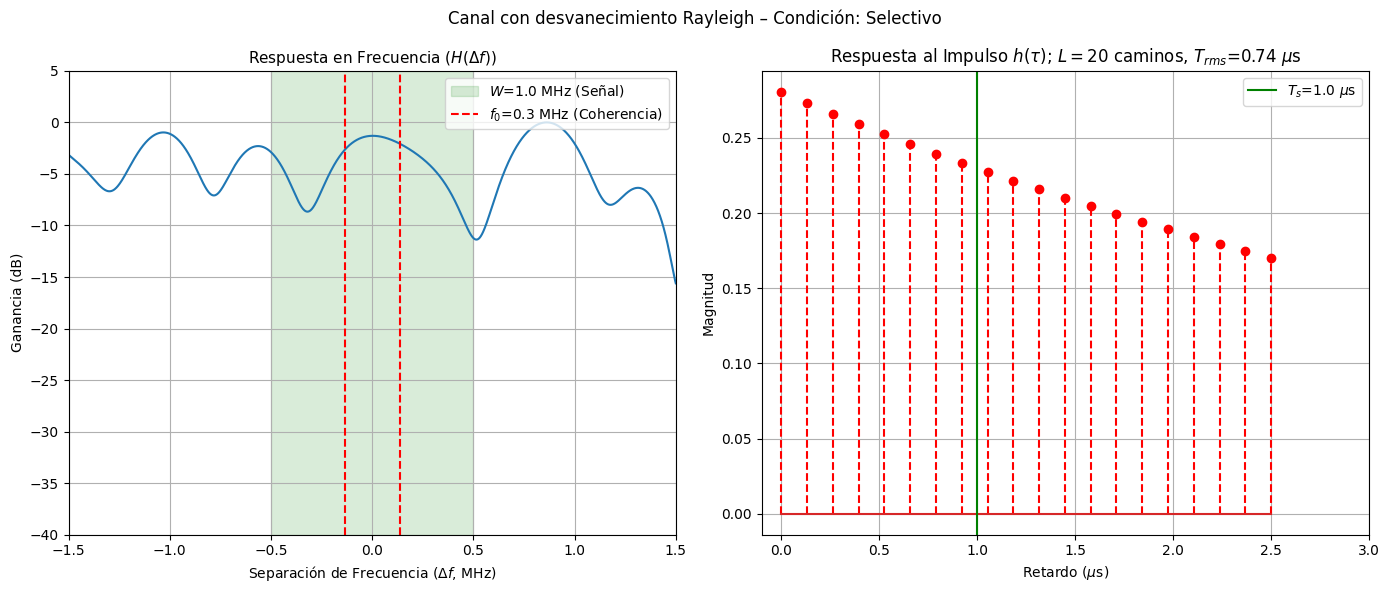

In [26]:
def simulate_multipath_channel(Tm_target, L, W_sig, T_s_target, decay_factor=1):
    """
    Simula la respuesta en frecuencia INSTANTÁNEA H(Δf) y el perfil S(tau) de un canal multipath.
    """
    #Retardos y Potencias (S(tau))
    tau_k = np.linspace(0, Tm_target, L)
    # Decaimiento más lento para ver más picos (decay_factor controla la rapidez del decaimiento)
    P_k_linear = np.exp(-tau_k / (Tm_target / (L*decay_factor)))
    P_k_linear /= np.sum(P_k_linear)
    
    # Fases Aleatorias (Respuesta INSTANTÁNEA)
    theta_k = 2 * np.pi * np.random.rand(L)

    # Ancho de Banda de Coherencia (f0)
    # T_rms (para la aproximación f0 = 1 / (5 * T_rms))
    tau_mean = np.sum(tau_k * P_k_linear)
    tau_sq_mean = np.sum(tau_k**2 * P_k_linear)
    T_rms = np.sqrt(tau_sq_mean - tau_mean**2)
    f0 = 1 / (5 * T_rms)
    
    #Dominio de la Frecuencia (H(Δf) = FFT{h(τ)})
    Delta_f = np.linspace(-1.5 * W_sig, 1.5 * W_sig, 2000) # 2000 puntos para más suavidad
    h_k_complex = np.sqrt(P_k_linear) * np.exp(1j * theta_k)
    H_Delta_f = np.zeros_like(Delta_f, dtype=complex)
    
    for k in range(L):
        H_Delta_f += h_k_complex[k] * np.exp(-1j * 2 * np.pi * Delta_f * tau_k[k])
        
    H_Delta_f_mag = np.abs(H_Delta_f) 
    # Normalizar para que el pico sea 0 dB
    H_Delta_f_dB = 20 * np.log10(H_Delta_f_mag / np.max(H_Delta_f_mag))
    
    # 5. Respuesta al Impulso (h(τ)): Coeficientes complejos para el eje de retardo
    h_tau_mag = np.abs(h_k_complex)
    
    return tau_k, h_tau_mag, T_rms, f0, Delta_f, H_Delta_f_dB

def graph_multipath_response_dual(Tm, L, T_rms, f0, T_s, W_sig, Delta_f, H_Delta_f_dB, tau_k, h_tau_mag, type=str):
    """
    Gráfica dual: Respuesta en Frecuencia (Izquierda) y Respuesta al Impulso (Derecha).
    """
    fading_type = "Selectivo" if T_rms > T_s / 5 else "Plano"
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Canal con desvanecimiento {type} – Condición: {fading_type}', fontsize=12)

    ax1 = axes[0]
    ax1.plot(Delta_f / 1e6, H_Delta_f_dB)
    
    # Resaltar la banda de la señal (W) y coherencia (f0)
    ax1.axvspan(-W_sig / 2 / 1e6, W_sig / 2 / 1e6, color='g', alpha=0.15, label=f'$W$={W_sig/1e6:.1f} MHz (Señal)')
    ax1.axvline(f0 / 2e6, color='r', linestyle='--', label=f'$f_0$={f0/1e6:.1f} MHz (Coherencia)')
    ax1.axvline(-f0 / 2e6, color='r', linestyle='--')
    
    ax1.set_title(f'Respuesta en Frecuencia ($H(\\Delta f)$)', fontsize=11)
    ax1.set_xlabel('Separación de Frecuencia ($\\Delta f$, MHz)')
    ax1.set_ylabel('Ganancia (dB)')
    ax1.set_ylim(-40, 5) 
    ax1.set_xlim(Delta_f.min() / 1e6, Delta_f.max() / 1e6)
    ax1.legend(loc='upper right')
    ax1.grid(True)

    ax2 = axes[1]

    ax2.stem(tau_k * 1e6, h_tau_mag, markerfmt='ro', linefmt='r--') 
    
    # Marcamos el Tiempo de Símbolo (Ts) como referencia
    ax2.axvline(T_s * 1e6, color='g', linestyle='-', label=f'$T_s$={T_s*1e6:.1f} $\\mu$s')
    
    ax2.set_title(f'Respuesta al Impulso $h(\\tau)$; $L={L}$ caminos, $T_{{rms}}$={T_rms*1e6:.2f} $\\mu$s')
    ax2.set_xlabel('Retardo ($\\mu$s)')
    ax2.set_ylabel('Magnitud')
    ax2.set_xlim(-0.1 * T_s * 1e6, (Tm + 0.5 * T_s) * 1e6) # Ajustar el eje X para el impulso
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# --- Parámetros de Simulación Base ---
T_s_new = 1e-6 # Tiempo de Símbolo: 1 mu s
W_new = 1 / T_s_new # Ancho de Banda: 1 MHz


# --- Escenario 1: Fading Plano (Flat Fading) ---
Tm_flat = 1.1e-6 # Retardo Máximo: 0.05 us (Tm << Ts)
L_flat = 15
T_s = T_s_new # Usamos 1 us como referencia
Tm = Tm_flat # Para la función de graficado

tau_flat, h_tau_mag_flat, T_rms_flat, f0_flat, Delta_f_flat, H_f_dB_flat = simulate_multipath_channel(Tm_flat, L_flat, W_new, T_s_new, decay_factor=0.5) 

graph_multipath_response_dual(Tm_flat, L_flat, T_rms_flat, f0_flat, T_s_new, W_new, Delta_f_flat, H_f_dB_flat, tau_flat, h_tau_mag_flat, "Rayleigh")


# --- Escenario 2: Fading Selectivo (Frequency Selective Fading) ---
Tm_sel = 2.5e-6 # Retardo Máximo: 1.0 us (Tm approx Ts)
L_sel = 20
Tm = Tm_sel # Para la función de graficado

tau_sel, h_tau_mag_sel, T_rms_sel, f0_sel, Delta_f_sel, H_f_dB_sel = simulate_multipath_channel(Tm_sel, L_sel, W_new, T_s_new, decay_factor=0.05) # Factor más bajo para ver decaimiento lento

graph_multipath_response_dual(Tm_sel, L_sel, T_rms_sel, f0_sel, T_s_new, W_new, Delta_f_sel, H_f_dB_sel, tau_sel, h_tau_mag_sel, "Rayleigh")

In [37]:
def rician_channel_adapted(V_kmh, f_c, T_sim, F_s, K_factor_dB):
    """
    Genera un proceso Rician o Rayleigh basado en el K-factor.
    Reutiliza la lógica de dispersión Doppler del modelo Jakes.
    """
    t, T_0, f_d, h_Rayleigh_t, _, _ = rayleigh_channel(V_kmh, f_c, T_sim, F_s)

    K_linear = 10**(K_factor_dB / 10)
    
    if K_linear <= 1e-6:
        mag_LOS = 0.0
        mag_diffuse = 1.0 
        K_print = 0.0 # Valor real de K
    else:
        # Rician: Distribuye la potencia entre LOS y Difuso (suma de potencias = 1)
        mag_LOS = np.sqrt(K_linear / (K_linear + 1))
        mag_diffuse = np.sqrt(1 / (K_linear + 1))
        K_print = K_linear

    LOS_t = np.exp(1j * 0) 
    
    h_rician_t = mag_LOS * LOS_t + mag_diffuse * h_Rayleigh_t
    
    r_t_magnitude = np.abs(h_rician_t)
    r_t_dB = 10 * np.log10(r_t_magnitude**2 / np.mean(r_t_magnitude**2)) # Normalizado
    
    print(f"\n--- Parámetros del Canal (V={V_kmh} km/h, K={K_factor_dB:.1f} dB) ---")
    print(f"Tipo de Fading: {'Rayleigh' if K_print < 1e-6 else 'Rician'}")
    print(f"Dispersión Doppler Máxima (f_d): {f_d:.2f} Hz")
    print(f"Tiempo de Coherencia Aproximado (T_0): {T_0*1e3:.2f} ms")

    return t, T_0, f_d, h_rician_t, r_t_dB, r_t_magnitude, K_factor_dB

def graph_rician_temp(x, y, v, fc, T_0, T_s, K_dB):
    """
    Representación en el Dominio del Tiempo, adaptada para Rician/Rayleigh.
    """
    if T_0 < T_s:
        print("Canal de Desvanecimiento Rápido (Fast Fading)")
    else:
        print("Canal de Desvanecimiento Lento (Slow Fading)")
    fading_type = 'Rayleigh' if K_dB <= 0.0 else 'Rician'
    
    plt.figure(figsize=(10, 5))
    plt.plot(x * 1000, y, label=f'Envolvente {fading_type} (K={K_dB:.1f} dB)') 
    plt.xlabel('Tiempo Transcurrido (ms)')
    plt.ylabel('Nivel de Señal (dB relativo a RMS)')
    plt.title(f'{fading_type} Fading (V={v} km/h, $f_c$={fc/1e9:.1f} GHz, $T_s$={T_s*1e3:.1f} ms)')
    plt.grid(True)
    plt.vlines(T_0 * 1000, -40, 10, colors='r', linestyles='dotted', label=f'$T_0 \\approx {T_0*1e3:.2f}$ ms')
    plt.vlines(T_s * 1000, -40, 10, colors='g', linestyles='solid', linewidth=5, alpha=0.3, label=f'$T_s$={T_s*1e3:.1f} ms')
    plt.ylim(-30, 5)
    plt.legend()
    plt.show()

def graph_rician_stadistical(magnitude, K_dB):
    """
    Representación Estadística para Rayleigh/Rician.
    """
    K_linear = 10**(K_dB / 10)
    
    plt.figure(figsize=(10, 5))
    plt.hist(magnitude, bins=50, density=True, color='skyblue', edgecolor='black', label='Simulación')
    
    # PDF Teórica (Rayleigh o Rician)
    r_range = np.linspace(0, magnitude.max(), 100)
    
    if K_linear <= 1e-6:
        # PDF Teórica Rayleigh (K=0)
        sigma_sq = np.mean(magnitude**2) / 2
        pdf_teorica = (r_range / sigma_sq) * np.exp(-r_range**2 / (2 * sigma_sq))
        label_teorica = 'Teórico Rayleigh PDF'
    else:
        sigma = np.sqrt(1 / (K_linear + 1)) 
        b = np.sqrt(K_linear) 
        
        pdf_teorica = rice.pdf(r_range, b=b, loc=0, scale=sigma)
        label_teorica = f'Teórico Rician PDF (K={K_dB:.1f} dB)'

    plt.plot(r_range, pdf_teorica, 'r-', linewidth=2, label=label_teorica)
    plt.title('PDF de la Envolvente del Desvanecimiento (Estadística)')
    plt.xlabel('Amplitud de la Envolvente')
    plt.ylabel('Densidad de Probabilidad')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()

Frecuencia Portadora (f_c): 0.9 GHz
Velocidad del móvil (V): 5.0 km/h (1.39 m/s)
Dispersión Doppler Máxima (f_d): 4.17 Hz
Tiempo de Coherencia Aproximado (T_0): 101.55 ms

--- Parámetros del Canal (V=5.0 km/h, K=10.0 dB) ---
Tipo de Fading: Rician
Dispersión Doppler Máxima (f_d): 4.17 Hz
Tiempo de Coherencia Aproximado (T_0): 101.55 ms
Canal de Desvanecimiento Lento (Slow Fading)


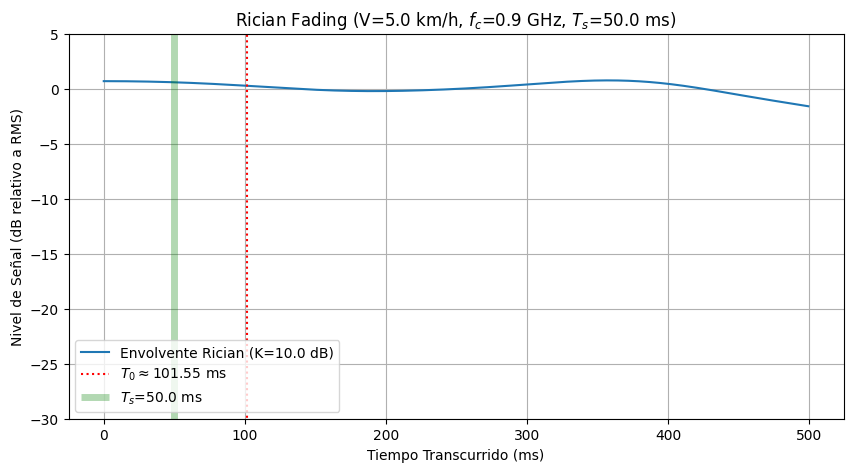

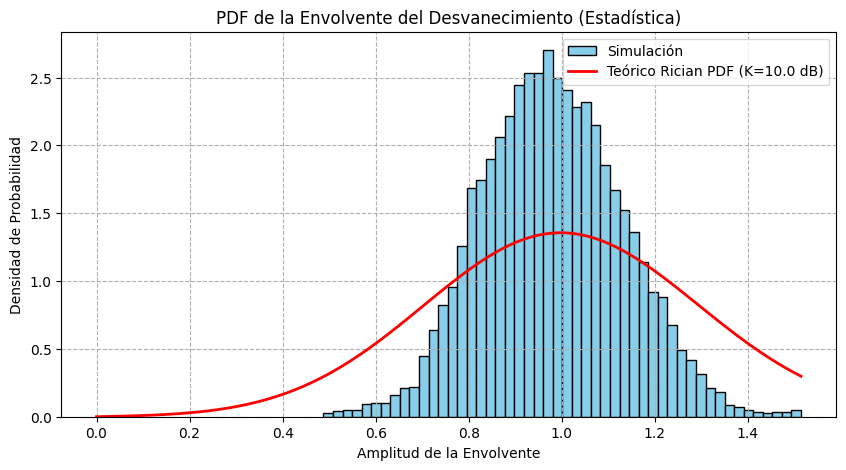

Frecuencia Portadora (f_c): 0.9 GHz
Velocidad del móvil (V): 80.0 km/h (22.22 m/s)
Dispersión Doppler Máxima (f_d): 66.67 Hz
Tiempo de Coherencia Aproximado (T_0): 6.35 ms

--- Parámetros del Canal (V=80.0 km/h, K=20.0 dB) ---
Tipo de Fading: Rician
Dispersión Doppler Máxima (f_d): 66.67 Hz
Tiempo de Coherencia Aproximado (T_0): 6.35 ms
Canal de Desvanecimiento Rápido (Fast Fading)


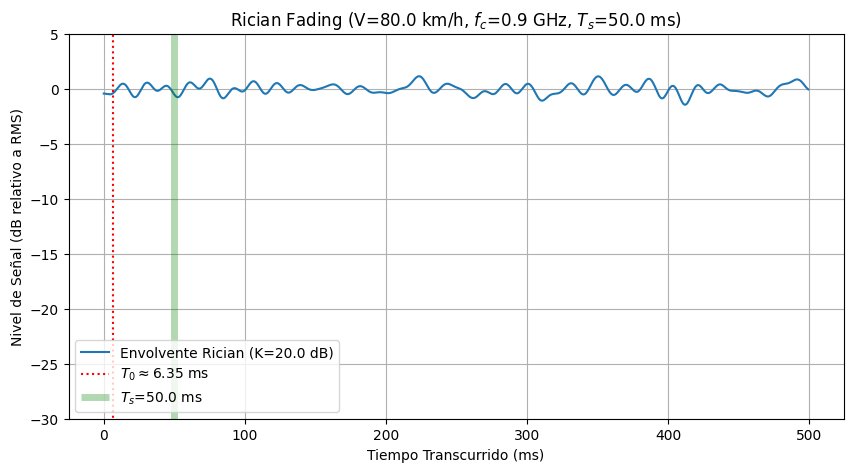

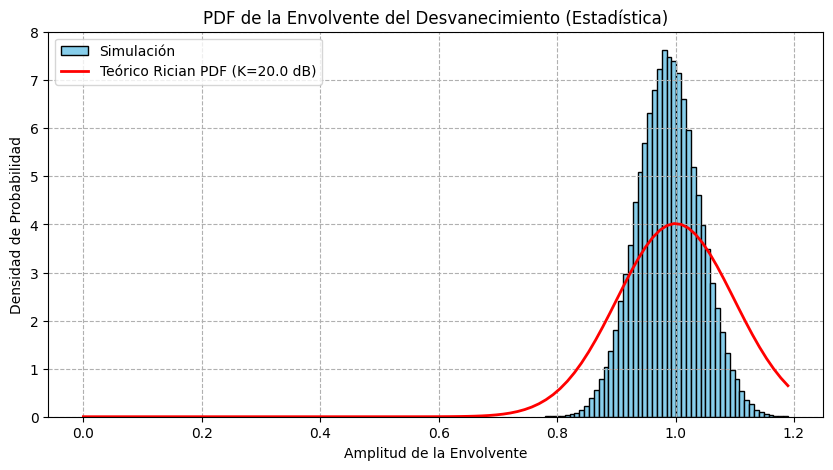

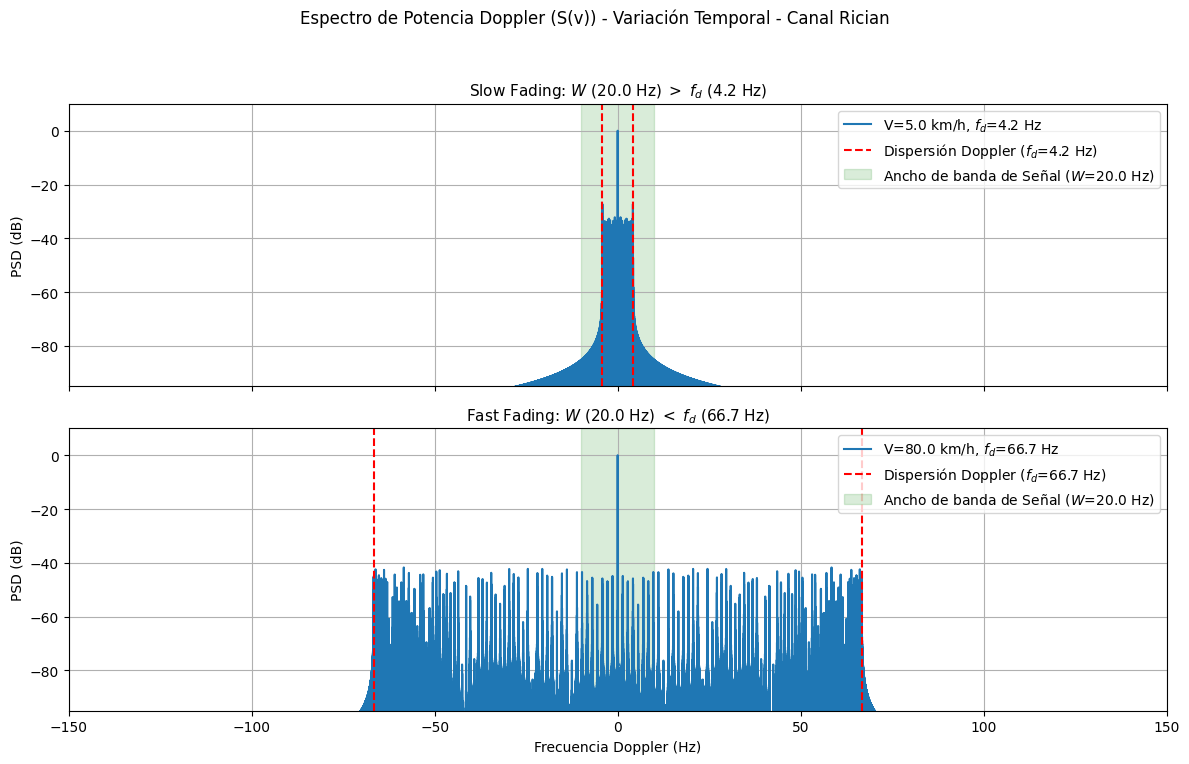

In [40]:
f_c = 0.9e9      
T_s = 50e-3      
T_sim = 100.0  
T_dur = 0.5   
F_s = 2000.0    

# Escenarios de Prueba: Velocidad y K-factor

# Rayleigh Lento
V_slow = 5.0
K_rayleigh = 10.0

t1, T0_slow, fd1, h1, r_dB1, r_mag1, K_dB1 = rician_channel_adapted(V_slow, f_c, T_sim, F_s, K_rayleigh)

graph_rician_temp(t1[:int(T_dur * F_s)], r_dB1[:int(T_dur * F_s)], V_slow, f_c, T0_slow, T_s, K_dB1)
graph_rician_stadistical(r_mag1, K_dB1)


# Rician Rápido
V_fast = 80.0
K_rician = 20.0

t2, T0_fast, fd2, h2, r_dB2, r_mag2, K_dB2 = rician_channel_adapted(V_fast, f_c, T_sim, F_s, K_rician)
graph_rician_temp(t2[:int(T_dur * F_s)], r_dB2[:int(T_dur * F_s)], V_fast, f_c, T0_fast, T_s, K_dB2)
graph_rician_stadistical(r_mag2, K_dB2)


v_fast, S_v_fast_dB = calculate_doppler_spectrum_corrected(h2, F_s)
v_slow, S_v_slow_dB = calculate_doppler_spectrum_corrected(h1, F_s)
# Gráfica Comparativa del Espectro Doppler
graph_doppler(v_slow, S_v_slow_dB, fd1, V_slow, v_fast, S_v_fast_dB, fd2, V_fast, W, "Rician", xlim=(-150, 150), ylim=(-95,10))

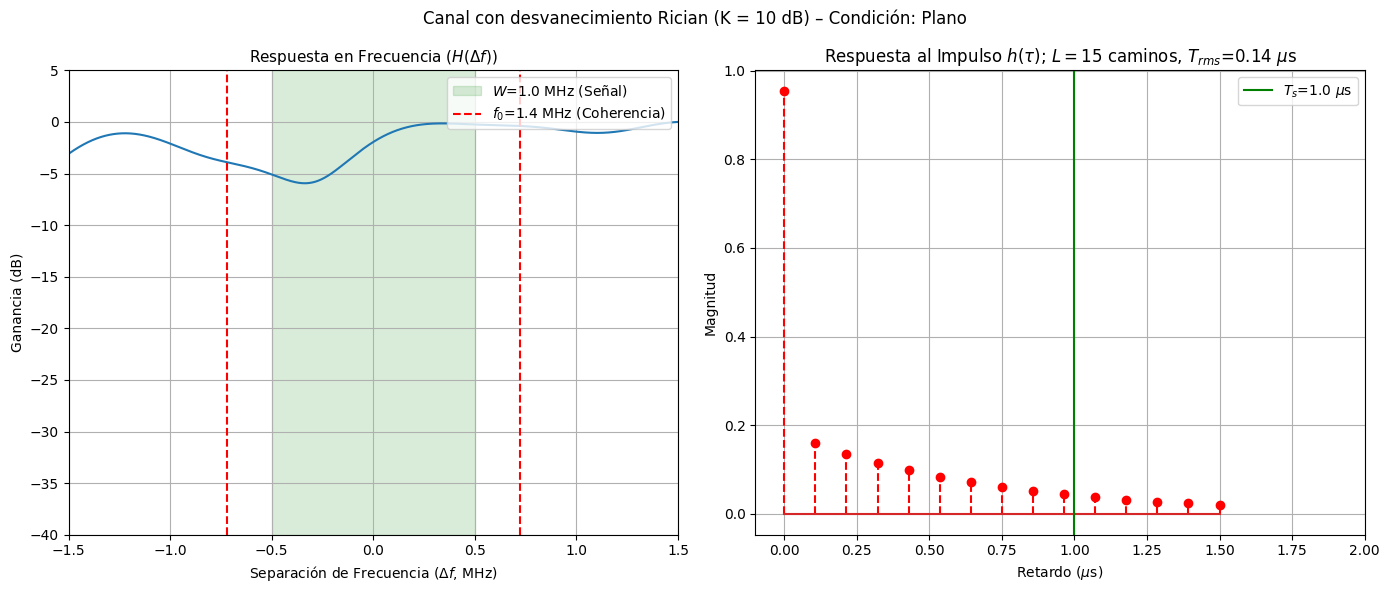

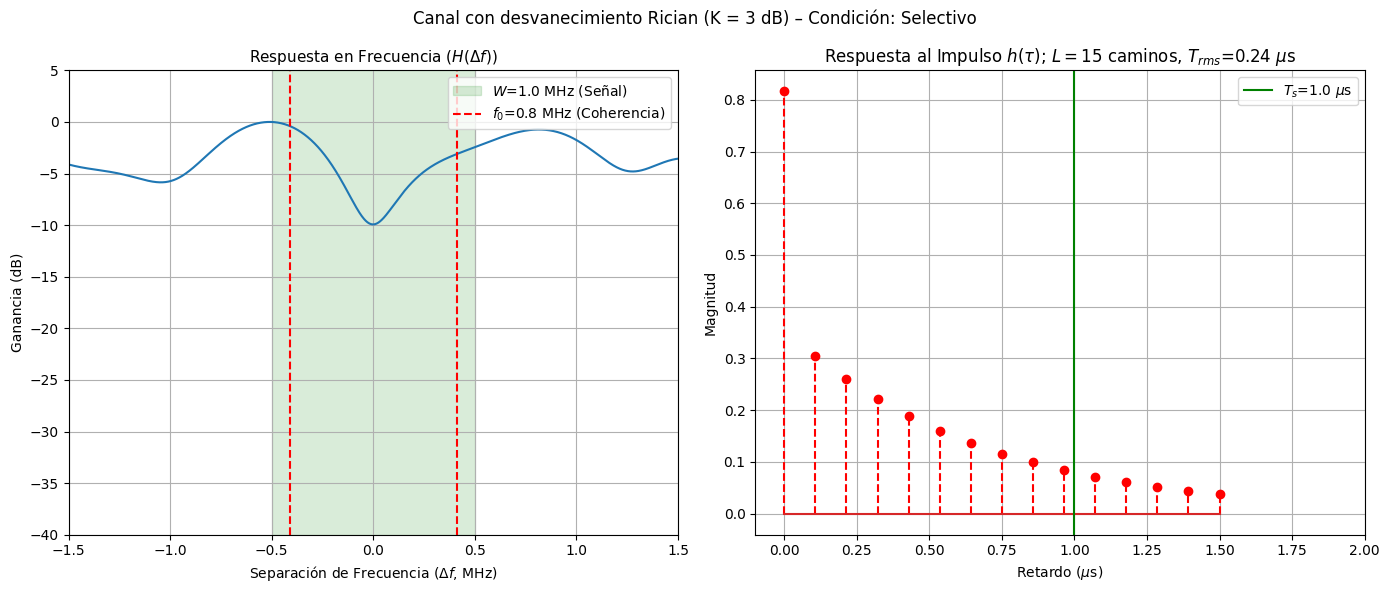

In [34]:
def rician_multipath_channel(Tm_target, L, W_sig, T_s_target, K_factor_dB, decay_factor=1):
    """
    Simula la respuesta en frecuencia INSTANTÁNEA H(Δf) de un canal multipath Rician.
    
    K_factor_dB: Factor Rician K en dB. K=0 dB es Rayleigh.
    """

    K_linear = 10**(K_factor_dB / 10)
    

    tau_k = np.linspace(0, Tm_target, L)

    P_base_linear = np.exp(-tau_k / (Tm_target / (L * decay_factor)))
    
    # Potencia total Difusa y LOS (normalizadas a 1)
    P_LOS = K_linear / (K_linear + 1)
    P_DIFF_TOTAL = 1 / (K_linear + 1)
    
    # Normalización del patrón base (solo la suma de los L-1 caminos difusos)
    P_base_normalized = P_base_linear / np.sum(P_base_linear)

    # Coeficientes complejos (magnitud y fase)
    h_k_complex = np.zeros(L, dtype=complex)
    
    # a) Componente LOS (Primer camino, tau_0 = 0)
    # La potencia LOS se asigna al primer camino, con fase fija (no aleatoria)
    h_k_complex[0] = np.sqrt(P_LOS) * np.exp(1j * 0) 
    
    # b) Componentes Difusas (Rayleigh)
    # Genera fases aleatorias (solo L-1 fases para los caminos difusos)
    theta_diffuse = 2 * np.pi * np.random.rand(L - 1)
    
    P_diff_path_normalized = P_base_linear[1:] / np.sum(P_base_linear[1:])
    
    for k in range(1, L):
        # Magnitud de cada eco difuso: sqrt(P_DIFF_TOTAL * P_normalizado_k)
        P_k_diffuse = P_DIFF_TOTAL * P_diff_path_normalized[k-1]
        h_k_complex[k] = np.sqrt(P_k_diffuse) * np.exp(1j * theta_diffuse[k-1])
        
    # La potencia lineal total de todos los caminos
    P_k_total_linear = np.abs(h_k_complex)**2 
    
    # Ancho de Banda de Coherencia (f0) - Calculado sobre las potencias TOTALES
    tau_mean = np.sum(tau_k * P_k_total_linear)
    tau_sq_mean = np.sum(tau_k**2 * P_k_total_linear)
    T_rms = np.sqrt(tau_sq_mean - tau_mean**2)
    f0 = 1 / (5 * T_rms)
    
    # Dominio de la Frecuencia (H(Δf) = FFT{h(τ)})
    Delta_f = np.linspace(-1.5 * W_sig, 1.5 * W_sig, 2000)
    H_Delta_f = np.zeros_like(Delta_f, dtype=complex)
    
    for k in range(L):
        H_Delta_f += h_k_complex[k] * np.exp(-1j * 2 * np.pi * Delta_f * tau_k[k])
        
    H_Delta_f_mag = np.abs(H_Delta_f) 
    H_Delta_f_dB = 20 * np.log10(H_Delta_f_mag / np.max(H_Delta_f_mag))
    
    # 6. Respuesta al Impulso (h(τ)): Coeficientes
    h_tau_mag = np.abs(h_k_complex)
    
    return tau_k, h_tau_mag, T_rms, f0, Delta_f, H_Delta_f_dB, K_factor_dB

# --- EJECUCIÓN CON RICIAN ---

# Parámetros de Simulación Base
T_s_new = 1e-6 # Tiempo de Símbolo: 1 mu s
W_new = 1 / T_s_new # Ancho de Banda: 1 MHz

# --- Escenario Rician 1: K=10 dB (Dominante LOS) ---
Tm_rician = 1.5e-6
L_rician = 15
K_dB = 10.0 # 10 dB Rician
T_s = T_s_new 
Tm = Tm_rician 

tau1, h_tau_mag1, T_rms1, f01, Delta_f1, H_f_dB1, K_dB1 = rician_multipath_channel(
    Tm_rician, L_rician, W_new, T_s_new, K_dB, decay_factor=0.3)

# La función graph_multipath_response_dual debe actualizar su título para incluir K_dB
# Aquí asumimos que la función de gráfico está disponible.
# graph_multipath_response_dual(Tm, L_rician, T_rms1, f01, T_s, W_new, Delta_f1, H_f_dB1, tau1, h_tau_mag1, K_dB=K_dB1)

# --- Escenario Rician 2: K=3 dB (Menos Dominante) ---
K_dB_low = 3

tau2, h_tau_mag2, T_rms2, f02, Delta_f2, H_f_dB2, K_dB2 = rician_multipath_channel(
    Tm_rician, L_rician, W_new, T_s_new, K_dB_low, decay_factor=0.3)
graph_multipath_response_dual(Tm, L_rician, T_rms1, f01, T_s, W_new, Delta_f1, H_f_dB1, tau1, h_tau_mag1,"Rician (K = 10 dB)")
graph_multipath_response_dual(Tm, L_rician, T_rms2, f02, T_s, W_new, Delta_f2, H_f_dB2, tau2, h_tau_mag2,"Rician (K = 3 dB)")


